# MAE Poly Loss Analysis 

In [584]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import scipy.stats as stats

In [585]:
wd = os.getcwd()
data = os.path.join(wd, "data")
wd

'/Users/jakegwinn/Documents/argonne_F24/u.jw_analysis'

In [586]:
def residual_plot(data, alpha):
    y_true = data["auc_true"]
    y_pred = data["auc_pred"]
    
    residuals = y_true - y_pred
    
    plt.scatter(y_pred, residuals)
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.axhline(0, color='r', linestyle='--')
    plt.title(f"Residual Plot\nAlpha = {alpha}")
    
    plt.show()

In [587]:
def res_v_true(data, alpha, auc_max=1):
    y_true = data["auc_true"]
    y_pred = data["auc_pred"]
    
    residuals = y_true - y_pred
    
    mask = (y_true <= auc_max)
    y_true_filtered = y_true[mask]
    residuals_filtered = residuals[mask]
    
    
    coefficients = np.polyfit(y_true_filtered, residuals_filtered, deg=1)
    slope, intercept = coefficients
    best_fit_line = slope * y_true_filtered + intercept
    
    # Plot the best-fit line
    plt.plot(y_true_filtered, best_fit_line, color="red", label=f"Best Fit (True ≤ {auc_max})")
    
    plt.scatter(y_true, residuals)
    plt.xlabel("True Values")
    plt.ylabel("Residuals")
    plt.axhline(0, color='r', linestyle='--')
    plt.title(f"Residuals vs True Values Plot\nAlpha = {alpha}")
    plt.show()

In [588]:
def error_distrib(data, alpha):
    
    y_true = data["auc_true"]
    y_pred = data["auc_pred"]
    
    residuals = y_true - y_pred
    
    sns.histplot(residuals, kde=True)
    plt.xlabel("Residuals")
    plt.title(f"Error Distribution\nAlpha = {alpha}")
    
    plt.show()

In [589]:
def error_abs_distrib(data, alpha):
    
    y_true = data["auc_true"]
    y_pred = data["auc_pred"]
    
    residuals = y_true - y_pred
    
    sns.histplot(np.abs(residuals), kde=True)
    plt.xlabel("Residuals")
    plt.title(f"Absolute Value Error Distribution\nAlpha = {alpha}")
    
    plt.show()

In [590]:
def qqres_plot(data, alpha):
    
    y_true = data["auc_true"]
    y_pred = data["auc_pred"]
    
    residuals = y_true - y_pred
    studentized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)

    fig = sm.qqplot(studentized_residuals, line='45')
    # Customize plot
    plt.title(f"QQ Plot of Studentized Residuals\nAlpha = {alpha}")
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")
    plt.grid(True)
    plt.show()

## Base Case: Polynomial with degree 0 &rarr; MAE

In [591]:
folder = os.path.join(data, "basecase")
os.listdir(folder)
test_base = pd.read_csv(os.path.join(folder, "test_y_predicted_mae.csv"))

test_base.to_csv("test.tsv", sep="\t", index=False)

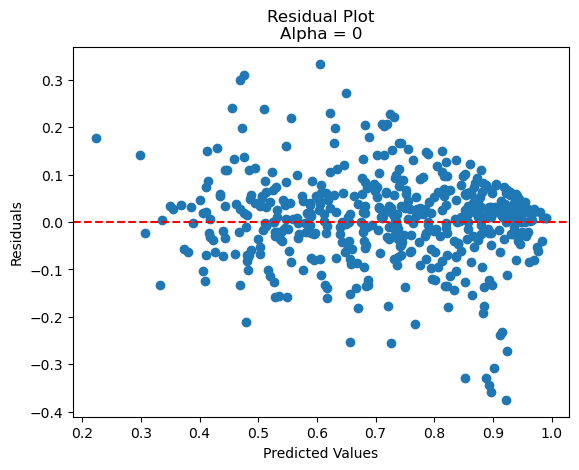

In [592]:
residual_plot(test_base, alpha=0)

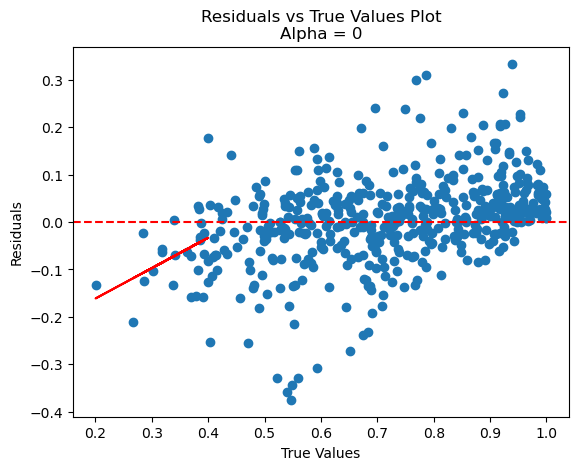

In [593]:
res_v_true(test_base, alpha=0, auc_max=0.4)

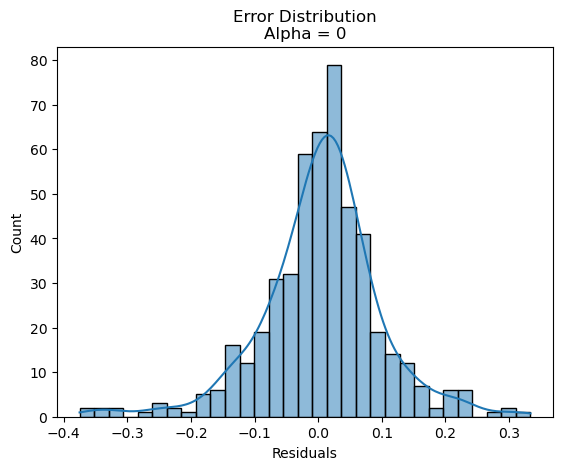

In [594]:
error_distrib(test_base, alpha=0)

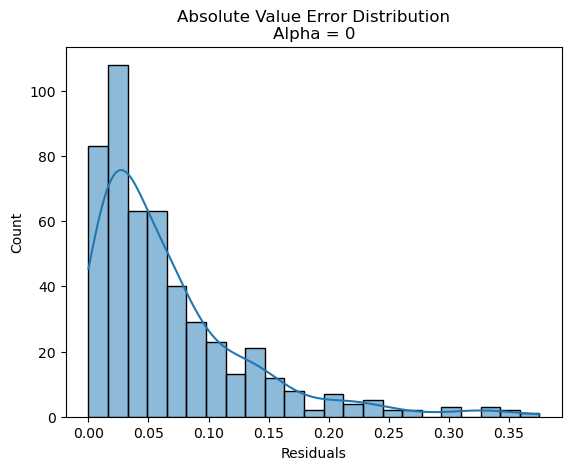

In [595]:
error_abs_distrib(test_base, alpha=0)

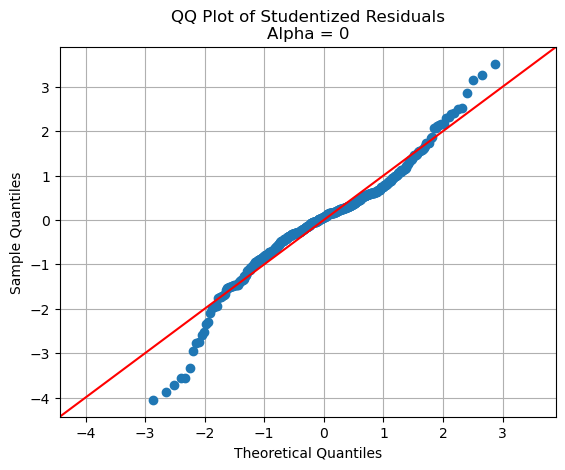

In [596]:
qqres_plot(test_base, alpha=0)

In [618]:
unique_samps = test_base["improve_sample_id"].unique()

data_dict = {}

for samp in unique_samps:
    true_order = test_base[test_base["improve_sample_id"] == samp].sort_values(by="auc_true", ascending = False).reset_index(drop = True)
    pred_order = true_order.sort_values(by="auc_pred", ascending = False)
    
    data_dict[samp] = {"true": true_order, "pred": pred_order}
    # break

# print(data_dict)

key_list = ["improve_sample_id", "spearman_all", "kendall_tau_val", "kendall_tau_pval"]
ranking_dict = {key: [] for key in key_list}

for key in data_dict.keys(): 
        
        rank_actual = data_dict[key]["true"]
        rank_predict = data_dict[key]["true"]
        
        sum1 = 0
    # Sum of difference squares (Σ d^2)
        sum2 = 0
        all = len(rank_actual)
        
        for i in range(0, all):
            # drug = rank_actual.iloc[i][2]
            # print("drug ", drug)
            # match = rank_predict.loc[rank_predict["improve_chem_id"] == drug]
            # print("match ", match.index.item())
            true_item = rank_actual["improve_chem_id"][i]
            # print(true_item)
            # print(rank_predict["improve_chem_id"][rank_predict["improve_chem_id"] == true_item])
            predicted_rank = rank_predict["improve_chem_id"][rank_predict["improve_chem_id"] == true_item].index[0]

            diff  = abs(i - predicted_rank)
            
            sum1 += diff
            diff2 = diff ** 2
            # print("diff2 ", diff2)
            sum2 += diff2
            # print("match ", str(match), " is ", )
        spearman_all = 1 - 6*sum2/(all*(all**2 - 1))
        ########################################################
        ranks_true = rank_actual.index.to_list()
        ranks_pred = rank_predict.index.to_list()
        kt = stats.kendalltau(ranks_true, ranks_pred)
        #######################################################
        
        ranking_dict["improve_sample_id"].append(key)
        ranking_dict["spearman_all"].append(spearman_all)
        ranking_dict["kendall_tau_val"].append(kt[0])
        ranking_dict["kendall_tau_pval"].append(kt[1])
        
print(pd.DataFrame(ranking_dict).to_string())


    improve_sample_id  spearman_all  kendall_tau_val  kendall_tau_pval
0          ACH-000948           1.0              1.0          0.083333
1          ACH-000219           NaN              NaN               NaN
2          ACH-000222           1.0              1.0          0.016667
3          ACH-000548           1.0              1.0          1.000000
4          ACH-000288           1.0              1.0          0.002778
5          ACH-000440           1.0              1.0          0.083333
6          ACH-000832           1.0              1.0          1.000000
7          ACH-000329           1.0              1.0          0.333333
8          ACH-000717           1.0              1.0          0.333333
9          ACH-000786           1.0              1.0          1.000000
10         ACH-000846           1.0              1.0          1.000000
11         ACH-000971           1.0              1.0          1.000000
12         ACH-000954           1.0              1.0          0.333333
13    

/var/folders/w_/tv9kwn955c59q5gycbr00lzh0000gn/T/ipykernel_11747/949456762.py:44: RuntimeWarning: invalid value encountered in scalar divide
  spearman_all = 1 - 6*sum2/(all*(all**2 - 1))


In [ ]:
from rbo import rbo

S = [1, 2, 3]

T = [1, 3, 2]

rbo.RankingSimilarity(S, T).rbo()

0.8333333333333334

## Polynomial with Degree 2

In [ ]:
folder = os.path.join(data, "maep2")
os.listdir(folder)
test_p2 = pd.read_csv(os.path.join(folder, "test_y_data_predicted_maep2.csv"))
test_p2

,improve_sample_id,improve_chem_id,auc,auc_true,auc_pred
0,ACH-000948,Drug_1163,0.9700,0.9700,0.8857
1,ACH-000219,Drug_1163,0.9061,0.9061,0.8580
2,ACH-000222,Drug_1163,0.9846,0.9846,0.9050
3,ACH-000548,Drug_1163,0.9246,0.9246,0.8772
4,ACH-000288,Drug_1163,0.9222,0.9222,0.8750
...,...,...,...,...,...
489,ACH-000638,Drug_1127,0.6032,0.6032,0.6236
490,ACH-000704,Drug_1127,0.5981,0.5981,0.5011
491,ACH-000042,Drug_1127,0.6009,0.6009,0.6299
492,ACH-000677,Drug_1127,0.5345,0.5345,0.5410


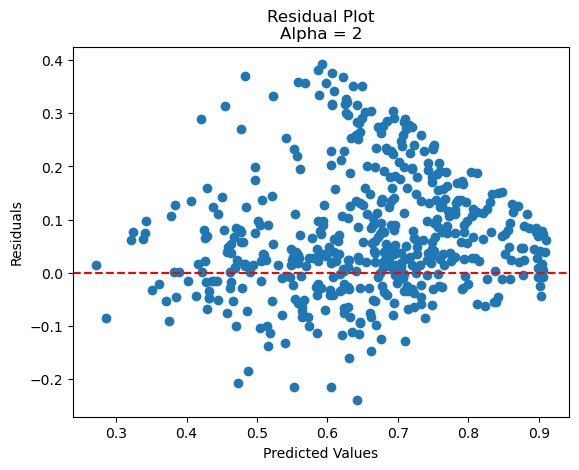

In [ ]:
residual_plot(test_p2, alpha=2)

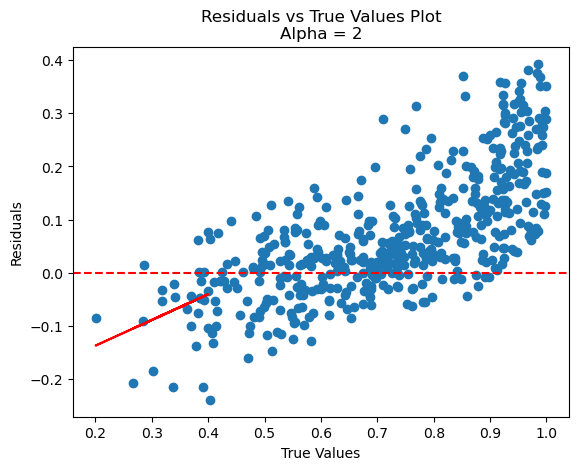

In [ ]:
res_v_true(test_p2, alpha=2, auc_max=0.4)

Line of best fit with lower values to see if push up

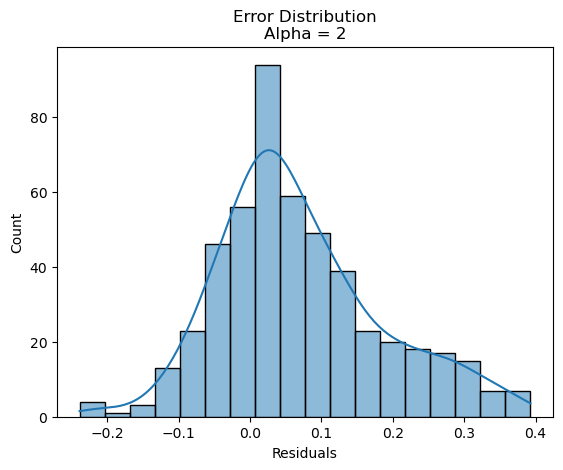

In [ ]:
error_distrib(test_p2, alpha=2)

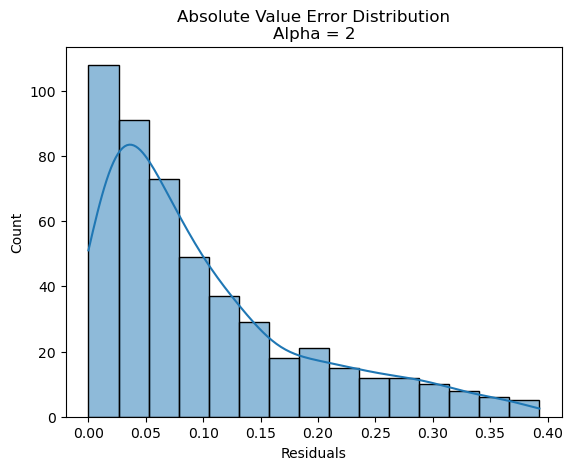

In [ ]:
error_abs_distrib(test_p2, alpha=2)

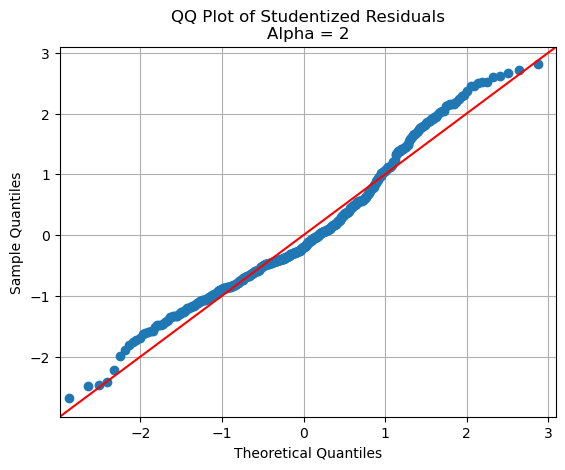

In [ ]:
qqres_plot(test_p2, alpha=2)

In [ ]:
df = test_p2[test_p2["auc_true"] < 0.4]
y_true = df["auc_true"]
y_pred = df["auc_pred"]
    
residuals = y_true - y_pred
np.mean(np.abs(residuals))

0.07703333333333333

In [617]:
unique_samps = test_p2["improve_sample_id"].unique()

data_dict = {}

for samp in unique_samps:
    true_order = test_p2[test_p2["improve_sample_id"] == samp].sort_values(by="auc_true", ascending = False).reset_index(drop = True)
    pred_order = true_order.sort_values(by="auc_pred", ascending = False)
    
    data_dict[samp] = {"true": true_order, "pred": pred_order}
    # break

# print(data_dict)

key_list = ["improve_sample_id", "spearman_all", "kendall_tau_val", "kendall_tau_pval"]
ranking_dict = {key: [] for key in key_list}

for key in data_dict.keys(): 
        
        rank_actual = data_dict[key]["true"]
        rank_predict = data_dict[key]["true"]
        
        sum1 = 0
    # Sum of difference squares (Σ d^2)
        sum2 = 0
        all = len(rank_actual)
        
        for i in range(0, all):
            # drug = rank_actual.iloc[i][2]
            # print("drug ", drug)
            # match = rank_predict.loc[rank_predict["improve_chem_id"] == drug]
            # print("match ", match.index.item())
            true_item = rank_actual["improve_chem_id"][i]
            # print(true_item)
            # print(rank_predict["improve_chem_id"][rank_predict["improve_chem_id"] == true_item])
            predicted_rank = rank_predict["improve_chem_id"][rank_predict["improve_chem_id"] == true_item].index[0]

            diff  = abs(i - predicted_rank)
            
            sum1 += diff
            diff2 = diff ** 2
            # print("diff2 ", diff2)
            sum2 += diff2
            # print("match ", str(match), " is ", )
        spearman_all = 1 - 6*sum2/(all*(all**2 - 1))
        ########################################################
        ranks_true = rank_actual.index.to_list()
        ranks_pred = rank_predict.index.to_list()
        kt = stats.kendalltau(ranks_true, ranks_pred)
        #######################################################
        
        ranking_dict["improve_sample_id"].append(key)
        ranking_dict["spearman_all"].append(spearman_all)
        ranking_dict["kendall_tau_val"].append(kt[0])
        ranking_dict["kendall_tau_pval"].append(kt[1])
        
print(pd.DataFrame(ranking_dict).to_string())

    improve_sample_id  spearman_all  kendall_tau_val  kendall_tau_pval
0          ACH-000948           1.0              1.0          0.083333
1          ACH-000219           NaN              NaN               NaN
2          ACH-000222           1.0              1.0          0.016667
3          ACH-000548           1.0              1.0          1.000000
4          ACH-000288           1.0              1.0          0.002778
5          ACH-000440           1.0              1.0          0.083333
6          ACH-000832           1.0              1.0          1.000000
7          ACH-000329           1.0              1.0          0.333333
8          ACH-000717           1.0              1.0          0.333333
9          ACH-000786           1.0              1.0          1.000000
10         ACH-000846           1.0              1.0          1.000000
11         ACH-000971           1.0              1.0          1.000000
12         ACH-000954           1.0              1.0          0.333333
13    

/var/folders/w_/tv9kwn955c59q5gycbr00lzh0000gn/T/ipykernel_11747/2037489859.py:44: RuntimeWarning: invalid value encountered in scalar divide
  spearman_all = 1 - 6*sum2/(all*(all**2 - 1))


## Polynomial with Degree 4

In [ ]:
folder = os.path.join(data, "maep4")
os.listdir(folder)
test_p4 = pd.read_csv(os.path.join(folder, "test_y_data_predicted_maep4.csv"))
test_p4

,improve_sample_id,improve_chem_id,auc,auc_true,auc_pred
0,ACH-000948,Drug_1163,0.9700,0.9700,0.5651
1,ACH-000219,Drug_1163,0.9061,0.9061,0.4688
2,ACH-000222,Drug_1163,0.9846,0.9846,0.6355
3,ACH-000548,Drug_1163,0.9246,0.9246,0.5474
4,ACH-000288,Drug_1163,0.9222,0.9222,0.5184
...,...,...,...,...,...
489,ACH-000638,Drug_1127,0.6032,0.6032,0.5652
490,ACH-000704,Drug_1127,0.5981,0.5981,0.4362
491,ACH-000042,Drug_1127,0.6009,0.6009,0.4850
492,ACH-000677,Drug_1127,0.5345,0.5345,0.5168


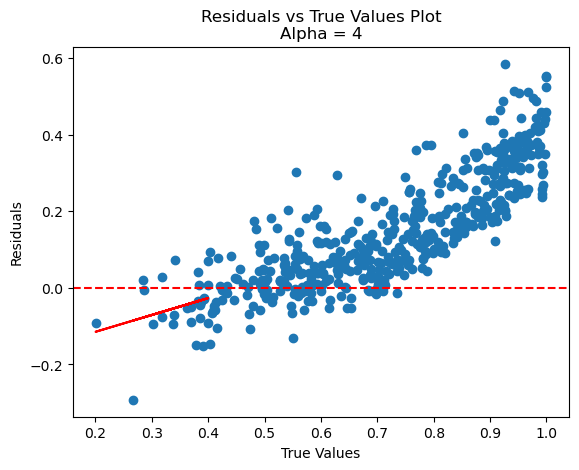

In [ ]:
res_v_true(test_p4, alpha=4, auc_max=0.4)

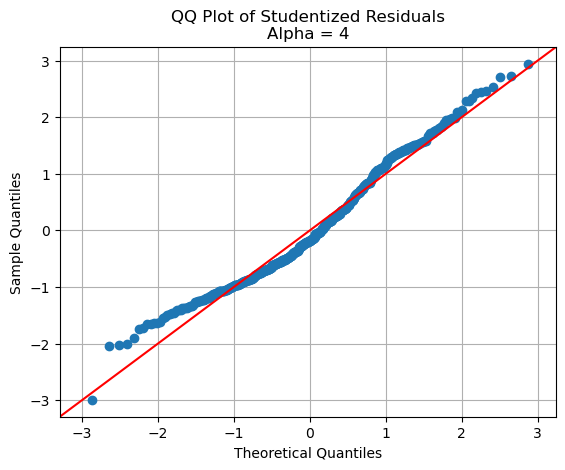

In [ ]:
qqres_plot(test_p4, alpha=4)

- zero inflated models --> logistic regression 
- log odds transformation 
    - Data transformation
- 

## Huber Loss

In [ ]:
data
folder = os.path.join(data, "huber")
os.listdir(folder)
test_hube = pd.read_csv(os.path.join(folder, "test_y_data_predicted_hube.csv"))
test_hube

resid_hube = test_hube["auc_true"] - test_hube["auc_pred"]
resid_p2 = test_p2["auc_true"] - test_p2["auc_pred"]

resid_hube == resid_p2

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jakegwinn/Documents/argonne_F24/u.jw_analysis/data/huber/test_y_data_predicted_hube.csv'

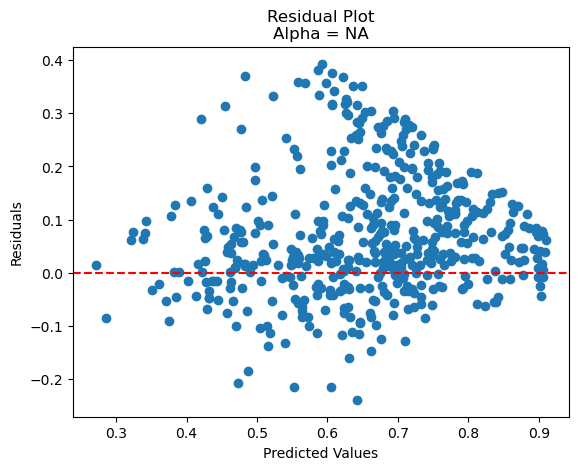

In [ ]:
residual_plot(test_hube, "NA")

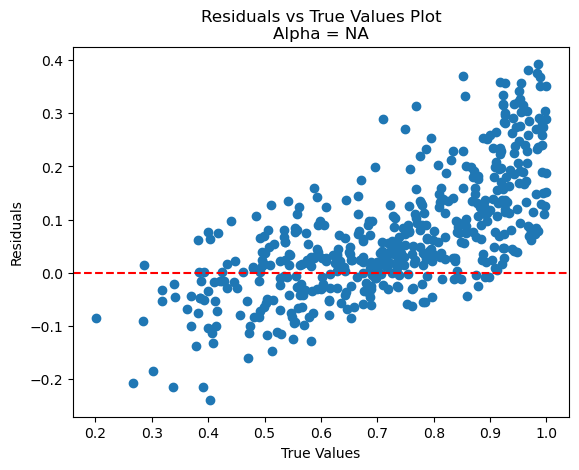

In [ ]:
res_v_true(test_hube, "NA")

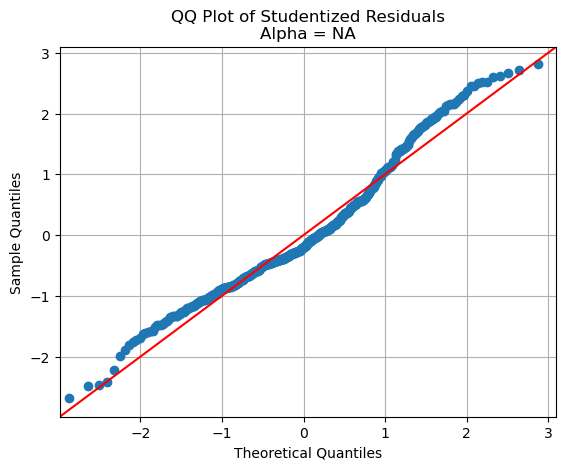

In [ ]:
qqres_plot(test_hube, "NA")

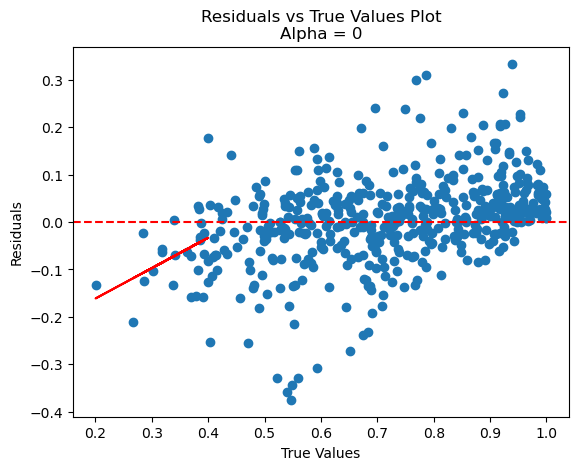

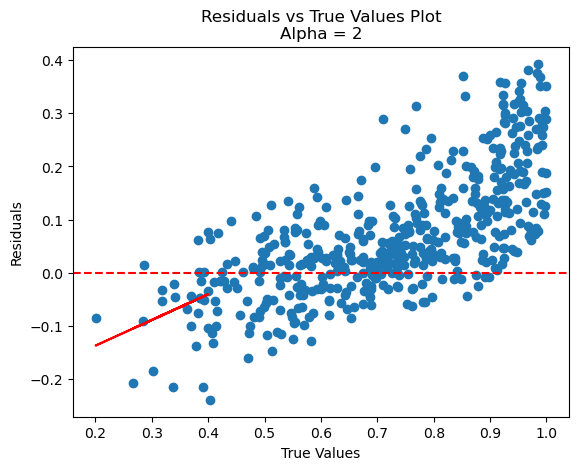

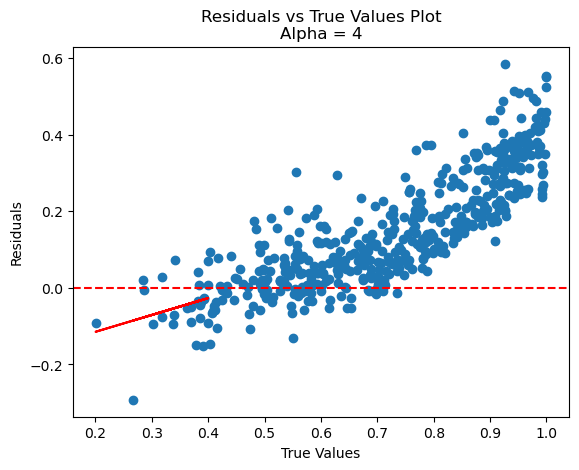

In [ ]:
res_v_true(test_base, alpha=0, auc_max=0.4)
res_v_true(test_p2, alpha=2, auc_max=0.4)
res_v_true(test_p4, alpha=4, auc_max=0.4)